Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

In [1]:
import helper_fxns as hf
import transforms as tr
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import requests
import sys
import time
%matplotlib inline

In [42]:
importlib.reload(hf)
importlib.reload(tr)

<module 'transforms' from 'C:\\Users\\Clinton\\Documents\\liver-mr-processor\\transforms.py'>

In [2]:
def reg_imgs(moving, fixed, params):
    fshape = fixed.shape
    mshape = moving.shape
    scale = [fshape[0]/mshape[0], fshape[1]/mshape[1], fshape[2]/mshape[2]]
    moving = tr.scale3d(moving, scale)
    moving = np.ascontiguousarray(moving).astype('float32')
    fixed = np.ascontiguousarray(fixed).astype('float32')

    moving, _ = pyelastix.register(moving, fixed, params, verbose=0)
    _, field = pyelastix.register(fixed, moving, params, verbose=0)
    return moving, scale, field

In [3]:
def scale_rois(x, y, z, pre_reg_scale, field=None, post_reg_scale=None):
    scale = pre_reg_scale
    x = (round(x[0]/scale[0]), round(x[1]/scale[0]))
    y = (round(y[0]/scale[1]), round(y[1]/scale[1]))
    z = (round(z[0]/scale[2]), round(z[1]/scale[2]))
    
    if field is not None:
        xroi_distortions = field[0][x[0]:x[1]+1, y[0]:y[1]+1, z[0]:z[1]+1]
        yroi_distortions = field[1][x[0]:x[1]+1, y[0]:y[1]+1, z[0]:z[1]+1]
        zroi_distortions = field[2][x[0]:x[1]+1, y[0]:y[1]+1, z[0]:z[1]+1]

        x = (x[0] + int(np.amin(xroi_distortions[0,:,:])), x[1] + int(np.amax(xroi_distortions[-1,:,:])))
        y = (y[0] + int(np.amin(yroi_distortions[:,0,:])), y[1] + int(np.amax(yroi_distortions[:,-1,:])))
        z = (z[0] + int(np.amin(zroi_distortions[:,:,0])), z[1] + int(np.amax(zroi_distortions[:,:,-1])))
    
        scale = post_reg_scale
        x = (round(x[0]/scale[0]), round(x[1]/scale[0]))
        y = (round(y[0]/scale[1]), round(y[1]/scale[1]))
        z = (round(z[0]/scale[2]), round(z[1]/scale[2]))
    
    return x, y, z

In [148]:
t2[mrn] = hf.dcm_load(subdir+r"\T2")

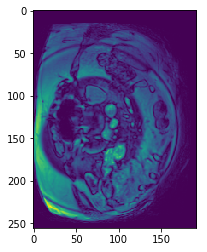

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(art['E105152534'][:,:,5])

In [164]:
art[mrn].shape

(288, 224, 72)

In [23]:
mrn = '13028374'
roi = (35, 43, 84, 92, 14, 15)
x=(roi[0], roi[1])
y=(roi[2], roi[3])
z=(roi[4], roi[5])

In [18]:
rois

[['13028374.npy', 65, 83, 140, 157, 18, 21, 'cyst'],
 ['13028374.npy', 35, 43, 84, 92, 14, 15, 'cyst'],
 ['13028374.npy', 31, 37, 107, 118, 7, 8, 'cyst'],
 ['12302576.npy', 156, 170, 248, 261, 10, 11, 'cyst'],
 ['12302576.npy', 118, 130, 248, 263, 15, 16, 'cyst'],
 ['12302576.npy', 79, 95, 181, 201, 6, 7, 'cyst'],
 ['12229245.npy', 96, 107, 146, 164, 31, 33, 'cyst'],
 ['E100314676.npy', 41, 53, 105, 118, 2, 4, 'cyst']]

In [21]:
x,y,z

((65, 83), (140, 157), (18, 21))

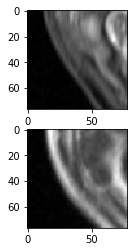

In [22]:
plot_section(mrn, x,y,z)

In [30]:
mrn = '12296182'

In [38]:
t2[mrn] = t2[mrn] * 255/np.amax(t2[mrn])

In [39]:
np.amax(t2[mrn])

Image(255.0, dtype=float32)

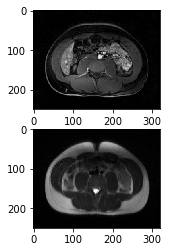

In [45]:
sl = 20
plt.subplot(211)
plt.imshow(np.transpose(art[mrn][:,::-1,sl], (1,0)), cmap='gray')
plt.subplot(212)
plt.imshow(np.transpose(t2[mrn][:,::-1,sl], (1,0)), cmap='gray')

In [4]:
def plot_section(mrn,x,y,z):
    plt.subplot(211)
    plt.imshow(np.transpose(art[mrn][x[0]-30:x[1]+30, y[1]+30:y[0]-30:-1, (z[0]+z[1])//2], (1,0)), cmap='gray')
    plt.subplot(212)
    plt.imshow(np.transpose(t2[mrn][x[0]-30:x[1]+30, y[1]+30:y[0]-30:-1, (z[0]+z[1])//2], (1,0)), cmap='gray')

In [5]:
def add_roi(mrn, x, y, z, cls):
    rois.append([str(mrn) + ".npy", x[0], x[1], y[0], y[1], z[0], z[1], cls])

def apply_mask(img, mask_file):
    with open(mask_file, 'rb') as f:
        mask = f.read()
        mask = np.fromstring(mask, dtype='uint8')
        mask = np.array(mask).reshape((img.shape[2], img.shape[1], img.shape[0]))
        mask = np.transpose(mask, (2,1,0))
        
    img[:,:,:,0][mask == 0] = 0

    return img

In [6]:
def preprocess_df(df):
    """Select only rows for this run. Collect MRNs and ROI coordinates."""
    df = df[(df['Run'] == 1) & (df['Image type'] == 'AP-T1')].dropna(subset=["x1"])
    return df.drop(set(df.columns).difference(['Patient E Number', 
          'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'Image type']), axis=1)

In [7]:
def load_imgs(df, base_dir, cls):
    """Create ROI file, apply whole liver mask, validate/scale dimensions"""

    def validate_dims(imgs, mrns):
        """Validate that all series of the same MRN have the same dimensions.
        Images formatted as list of dicts. Each dict is a different image channel, indexed by MRN."""
        for mrn in mrns:
            for x in range(1,len(imgs)):
                assert imgs[0][mrn].shape == imgs[x][mrn].shape, "img %s has wrong shape" % mrn
                
    pass

base_dir = r'raw_imgs\simple_cysts'
mrn = "12229245"
subdir = base_dir+"\\"+mrn
art[mrn] = hf.dcm_load(subdir+r"\T1_AP")
#pre[mrn] = hf.dcm_load(subdir+r"\T1_BL")
#ven[mrn] = hf.dcm_load(subdir+r"\T1_VP")
#equ[mrn] = hf.dcm_load(subdir+r"\T1_EQ")
t2[mrn] = hf.dcm_load(subdir+r"\T2")
t2[mrn], reg_scale = reg_imgs(moving=t2[mrn], fixed=art[mrn])
img = np.transpose(np.stack((art[mrn], t2[mrn])), (1,2,3,0))

mask_file = base_dir + "\\" + mrn + r'\00_segs\liver.ids'
mask = get_mask(img.shape, mask_file)
img[:,:,:,0][mask == 0] = 0

nonzeros = np.nonzero(mask)
try:
    minx, maxx = min(nonzeros[0]), max(nonzeros[0])
except:
    print(mask_file)
miny, maxy = min(nonzeros[1]), max(nonzeros[1])
minz, maxz = min(nonzeros[2]), max(nonzeros[2])
print(img.shape)
print("Crop:", minx, maxx, miny, maxy, minz, maxz)
img = img[minx:maxx, miny:maxy, minz:maxz, :]

#np.amax(art["12229245"][0])
#mask = get_mask(img.shape, "raw_imgs\simple_cysts\12229245\00_segs\liver.ids")

In [36]:
img.size

9081440

In [11]:
#pre = {}
art = {}
#ven = {}
#equ = {}
t2 = {}
field = {}
rois = []

base_dir = r'raw_imgs\simple_cysts'
cls='cyst'
df = pd.read_excel(r'raw_imgs\Prototype1CL.xlsx', sheetname="Hepatic Cyst")
df = preprocess_df(df)
#load_imgs(df, base_dir=r'raw_imgs\simple_cysts', cls='cyst')

params = pyelastix.get_default_params(type="RIGID")

img_dir = "full_imgs"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [12]:
def rescale(img, target_dims, cur_dims):
    vox_scale = [float(target_dims[i]/cur_dims[i]) for i in range(3)]
    img = tr.scale3d(img, vox_scale)
    
    return img, vox_scale

In [15]:
print("Loading DCMs...")
mrns = list(set(df['Patient E Number'].dropna().astype(str).tolist()))
s = time.time()
target_dims = [1.5,1.5,4]
rescale_time = 0
load_time = 0
reg_time = 0

for cnt, mrn in enumerate(mrns):
    subdir = base_dir+"\\"+mrn
    
    t_load = time.time()
    art[mrn], cur_dims = hf.dcm_load(subdir+r"\T1_AP")
    #pre[mrn] = hf.dcm_load(subdir+r"\T1_BL")
    #ven[mrn] = hf.dcm_load(subdir+r"\T1_VP")
    #equ[mrn] = hf.dcm_load(subdir+r"\T1_EQ")
    t2[mrn], _ = hf.dcm_load(subdir+r"\T2")
    load_time += time.time() - t_load
    
    df_subset = df.loc[df['Patient E Number'].astype(str) == mrn]

    t_reg = time.time()
    t2[mrn], reg_scale, field[mrn] = reg_imgs(moving=t2[mrn], fixed=art[mrn], params=params)
    t2[mrn] = t2[mrn] * 255/np.amax(t2[mrn])
    reg_time += time.time() - t_reg

    img = np.transpose(np.stack((art[mrn], t2[mrn])), (1,2,3,0))

    #mask_file = base_dir + "\\" + mrn + r'\00_segs\liver.ids'
    #img = apply_mask(img, mask_file)

    nonzeros = np.nonzero(img)
    minx, maxx = min(nonzeros[0]), max(nonzeros[0])
    miny, maxy = min(nonzeros[1]), max(nonzeros[1])
    minz, maxz = min(nonzeros[2]), max(nonzeros[2])
    img = img[minx:maxx, miny:maxy, minz:maxz, :]

    np.save(img_dir + "\\" + mrn, img)
    
    t_scale = time.time()
    img, vox_scale = rescale(img, target_dims, cur_dims)
    rescale_time += time.time() - t_scale
    
    for _, row in df_subset.iterrows():
        x = (int(row['x1']), int(row['x2']))
        y = (int(row['y1']), int(row['y2']))
        z = (int(row['z1']), int(row['z2']))

        y = (art[mrn].shape[1]-y[1], art[mrn].shape[1]-y[0]) # flip y
        z = (art[mrn].shape[2]-z[1], art[mrn].shape[2]-z[0]) # flip z
        
        t_scale = time.time()
        if cls == "cyst":
            x,y,z = scale_rois(x, y, z, reg_scale, field[mrn], vox_scale)
        else:
            x,y,z = scale_rois(x, y, z, vox_scale)
        rescale_time += time.time() - t_scale

        x = (x[0] - minx, x[1] - minx)
        y = (y[0] - miny, y[1] - miny)
        z = (z[0] - minz, z[1] - minz)

        add_roi(mrn, x,y,z, cls)

    print(mrn, "%d out of %d MRNs loaded" % (cnt+1, len(mrns)))
#validate_dims([t2, art], mrns)
print("Overall time: %s" % str(time.time() - s))
print("Time to load dcms: %s" % str(load_time))
print("Time rescaling: %s" % str(rescale_time))
print("Time registering: %s" % str(reg_time))

#s = time.time()
#print("Time to mask, crop, load rois, and save .npy files: %s" % str(time.time() - s))

Loading DCMs...
12972894 1 out of 8 MRNs loaded
12905568 2 out of 8 MRNs loaded
13010227 3 out of 8 MRNs loaded
E104657225 4 out of 8 MRNs loaded
13064153 5 out of 8 MRNs loaded
E103599300 6 out of 8 MRNs loaded
E101047106 7 out of 8 MRNs loaded
E105152534 8 out of 8 MRNs loaded
Overall time: 755.5933058261871
Time to load dcms: 82.65114212036133
Time rescaling: 6.601333856582642
Time registering: 634.1310482025146


In [14]:
base_dir = r'raw_imgs\OPTN5A'
cls='hcc'
df = pd.read_excel(r'raw_imgs\Prototype1CL.xlsx', sheetname="OPTN 5A")
df = preprocess_df(df)
#load_imgs(df, base_dir = r'raw_imgs\OPTN5A', cls='hcc')

In [ ]:
with open('train_list.txt', 'w') as f:
    for roi in rois:
        f.write(",".join([str(x) for x in roi]) + "\n")

In [ ]:
def draw_fig(image_array, name):
    """Draw an image of type np array and save it to."""

    image_array = image_array[:,:,slice_index]
    aspect = float(image_array.shape[1]) / image_array.shape[0]
    w = 20
    h = int(aspect * w)

    image_array = np.rot90(image_array)

    fig = plt.figure(frameon=False)
    fig.set_size_inches(w,h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image_array, interpolation='bilinear', norm=cnorm, cmap=plt.cm.gray, aspect='auto')

    img_fname = name + '.png'
    plt.savefig(img_fname)
    print('Segmentation saved as %s' % img_fname)

In [ ]:
def create_features(name, precontrast, arterial, liver_mask_file, tumor_mask_file, format_output, header_output, seg, slice_index):
    diff = art_data - pre_data # Calculate the subtracted image.
    diff[diff < 0] = 0.0  # The pre-contrast should never be more than the arterial. Clamp negative values to zero.

    x, y, z = diff.shape

    ##### Begin code for drawing specific mask slices. ######
    cnorm = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(diff))

    draw_fig(diff, 'whole')

    # Calculate the liver volume.
    liver_volume = np.sum(liver) * pre_dimx * pre_dimy * pre_dimz
    is_in_mm = pre_units == 2 or liver_volume > 10000
    if is_in_mm: # 2 is the code for millimeter, we convert to cubic centimeters.
        liver_volume /= 1000

    tumor_volume = np.sum(tumor) * pre_dimx * pre_dimy * pre_dimz
    if is_in_mm: # 2 is the code for millimeter, we convert to cubic centimeters.
        tumor_volume /= 1000

    mean_intensity = np.mean(diff[img > 0])
    std_intensity = np.std(diff[img > 0])

    # Calculate the volume of tumor that whose voxel intensities are greater than the mean liver intensity.
    # Note this is NOT the same threshold as qEASL (which would need a parenchymal ROI in order to define the intensity threshold).
    enhancing_tumor_volume = np.sum(tumor[just_tumor > mean_liver_intensity]) * pre_dimx * pre_dimy * pre_dimz
    if is_in_mm: # 2 is the code for millimeter, we convert to cubic centimeters.
        enhancing_tumor_volume /= 1000

    headers = ['Name', 'Liver volume', 'Mean liver intensity', 'STD liver intensity', 'Tumor volume', 'Mean tumor intensity', 'STD tumor intensity', 'Enhancing tumor volume']
    features = [name, liver_volume, mean_liver_intensity, std_liver_intensity, tumor_volume, mean_tumor_intensity, std_tumor_intensity, enhancing_tumor_volume]
    if format_output == 'tabulate':
        if header_output:
            results = tabulate.tabulate([features], headers=headers)
        else:
            results = tabulate.tabulate([features])
    else:
        features_row = '\t'.join(str(feature) for feature in features)
        if header_output:
            results = '\t'.join(headers) + '\n' + features_row
        else:
            results = features_row

    print(results)

In [ ]:
def training_pipeline(pre_dcm_fns, post_dcm_fns, labels):
    """
    pre_dcm_fn is the precontrast image, and post_dcm_fn is the postcontrast image
    1. Import pre/20s DICOMs
    2. Register pre to 20s
    3. Segment whole liver
    4. Obtain labels for HCC/non-HCC, as well as (HCC severity or survival?)
    5. For HCC labels, calculate and store embeddings (feature values)
    6. Train CNN on all
    7. Train feature engineered network on HCC labels
    """
    train_frac = 0.7
    data_size = len(pre_dcm_fns)
    
    # TODO: do a proper k-fold x-validation split
    X_cnn_train = X_cnn[:data_size*train_frac]
    X_cnn_val = X_cnn[data_size*train_frac:]
    
    for x in range(data_size):
        pre_dcm_fn = pre_dcm_fns[x]
        post_dcm_fn = post_dcm_fn[x]
        label = labels[x]
        
        pre_img = dcm_load(pre_dcm_fn)
        post_img = dcm_load(post_dcm_fn)

        pre_img = seg_liver(pre_img)
        post_img = seg_liver(post_img)
        
        y_cnn = label['is-hcc']
        label.pop('is-hcc')
        X_cnn = [pre_img, post_img, label]
        
        """if y_cnn:
            features = get_features(pre_img, post_img, label)
            
            # rfm is random forest model
            y_rfm = label
            X_rfm = [pre_img, post_img, label]"""

# Overall approach
This is a tool for classifying precontrast and 20s postcontrast MRIs (into LI-RADS stages / predicting survival?).

#### Training
-In mini-batches:
1. Import pre/20s DICOMs
2. Register pre to 20s
3. Segment whole liver
4. Obtain labels for HCC/non-HCC, as well as (HCC severity or survival?)
5. For HCC labels, calculate and store embeddings (feature values)
6. Train CNN on all

-After CNN is trained, then:
7. Train feature engineered network on HCC labels

#### Test pipeline:
1. Import pre/20s DICOMs
2. Register pre to 20s
3. Segment whole liver
4. Use CNN to classify as HCC/non-HCC
5. If HCC, calculate features values
6. If HCC, use feature engineered network to predict label

#### CNN models
First, try VGGNet, then ResNet. Then try VAE-GAN, training on benign only; deviation score = malignancy.